# Bike Sharing Dataset

## Introduction

**Dataset Source**: [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) or mirror at [data.world](https://data.world/uci/bike-sharing-dataset).

**Tasks**:

The dataset is split into two parts: the **last 30 days** for prediction and the **rest** for training and analysis.

- **Part 1**: Set up a Python 3 virtual environment and load the dataset.
- **Part 2**: Process, clean, and visualize the data, compute bike requirements, and analyze coverage.
- **Part 3**: Build and evaluate a Random Forest model to predict daily bike demand.
- **Part 4**: Provide reflections and comments.

**Setup Instructions**:
1. Create a Python 3 virtual environment _(I usually use [`uv`](https://docs.astral.sh/uv/) but here the instruction with classical python)_:
   ```bash
   python3 -m venv venv
   source venv/bin/activate  # On Windows: venv\Scripts\activate
   ```
2. Install required packages:
   ```bash
   pip install -r requirements.txt
   ```
3. Download `day.csv` from the UCI repository and place it in the same directory as this notebook.

**Notebook Structure**:
- **Imports and Setup**: Load libraries and configure plotting.
- **Data Loading and Cleaning**: Load and preprocess the dataset.
- **Data Analysis and Visualization**: Visualize rentals and compute bike requirements.
- **Prediction Model**: Build and evaluate a Random Forest model.
- **Reflection**: Provide comments and insights.

**A priori intuitions**:
- Who likes to ride under the **rain**? Not many people. But some are forced to do so, e.g. to go to work.
- **Summer** is a better time to rent bikes than winter.
- **Casual rentals** happens during the weekend and are very much weather dependant. Hence, high variance is expected.
- **Registered rentals** are more stable because people must go to work whatever the weather.
- During **holidays/breaks**, the number of registered rentals decreases because people do not go to work.

## Imports and Setup

In [19]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

# Configure plotting
plt.rcParams["font.family"] = "monospace"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams["mathtext.fontset"] = "cm"  # Consistent font for math text

# Create saving folder
from pathlib import Path
saving_dir = Path().parent / "saving_dir"
saving_dir.mkdir(exist_ok=True)

## Part 1: Data Loading and Environment Preparation

**Objective**: Load the UCI Bike Sharing Dataset and split it into two parts: the last 30 days (`df_last30`) and the rest (`df`). The split isolates the last 30 days for prediction, using the rest for training and analysis.

**Steps**:
- Load `day.csv` into a pandas DataFrame.
- Convert the `dteday` column to datetime for time-based operations.
- Add a `weekday_name` column for better interpretability.
- Split the dataset as specified.

In [20]:
# Load dataset
df_all = pd.read_csv("day.csv")

# Check for NaN and invalid values
assert not df_all.isnull().sum().any(), "NaN values detected"
assert df_all[df_all["cnt"] < 0].empty, "Negative rental counts detected"

# Convert date to datetime
df_all["dteday"] = pd.to_datetime(df_all["dteday"])

# Map weekday numbers to names (0=Sunday, based on workingday==0)
weekday_map = {0: "Sun", 1: "Mon", 2: "Tue", 3: "Wed", 4: "Thu", 5: "Fri", 6: "Sat"}
df_all["weekday_name"] = df_all["weekday"].map(weekday_map)

In [21]:
# Count holidays
df_holiday = df_all[df_all["holiday"] == 1]
print(f"{len(df_holiday)} holiday days over 2 years:")
print(df_holiday["weekday_name"].value_counts())

21 holiday days over 2 years:
Mon    15
Fri     2
Thu     2
Wed     1
Tue     1
Name: weekday_name, dtype: int64


Observation:
- Many Mondays (15 over 2 years)!

Cleaning the data? What should be removed?
- **I think it really depends on the tasks!**
- Instead of dropping the holidays breaks, I propose to **add this missing info to the dataset**.

In [22]:
# Add school holiday breaks - may not be exact (got them from quick websearch)
# In particular, end of Summer Break not clear
breaks = [
    {"name": "2011 Spring Break", "start": "2011-04-18", "end": "2011-04-22"},
    {"name": "2011 Summer Break", "start": "2011-06-18", "end": "2011-08-29"},
    {"name": "2011 Thanksgiving Break", "start": "2011-11-24", "end": "2011-11-25"},
    {"name": "2011 Winter Break", "start": "2011-12-22", "end": "2012-01-02"},
    {"name": "2012 Spring Break", "start": "2012-04-02", "end": "2012-04-06"},
    {"name": "2012 Summer Break", "start": "2012-06-15", "end": "2012-08-26"},
    {"name": "2012 Thanksgiving Break", "start": "2012-11-21", "end": "2012-11-23"},
    {"name": "2012 Winter Break", "start": "2012-12-24", "end": "2012-12-31"},
]
df_all["holiday_break"] = 0
for br in breaks:
    mask = (df_all["dteday"] >= pd.to_datetime(br["start"])) & (
        df_all["dteday"] <= pd.to_datetime(br["end"])
    )
    df_all.loc[mask, "holiday_break"] = 1

In [23]:

# Split dataset
df_last30 = df_all.tail(30).copy()
df = df_all.iloc[:-30, :].copy()

# Display first few rows of training data
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday_name,holiday_break
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,Sat,0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,Sun,0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,Mon,0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,Tue,0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,Wed,0


## Part 2: Data Processing and Analysis

**Objective**: Clean the data, visualize rentals, compute the maximum and 95th percentile of bikes needed, and analyze coverage.

**Steps**:
- **Cleaning**: Remove the Hurricane Sandy outlier (2011-10-29) and check for other outliers using a rolling z-score.
- **Visualization**: Plot daily rentals with holidays and school breaks, humidity vs. weather situation, and rentals by weekday.
- **Bike Requirements**: Calculate bikes needed per day (assuming 12 rentals per bike), find `nmax` (maximum) and `n95` (95th percentile).
- **Coverage Analysis**: Visualize the percentage of days covered for varying fleet sizes.

**Reasoning**:
- **Outliers**: Hurricane Sandy (2011-10-29) is removed due to its extreme low rental count (22). Other outliers are identified but not removed to preserve data, as they may reflect real variations. It is hard to distinguish if an outlier point is explainable by the weather (in which case it should be kept) or by external circumstances (in which case it should be dropped not to confuse the model).
- **Visualizations**: Daily rentals show trends and seasonality, holidays/school breaks highlight demand drops, and weekday analysis separates casual vs. registered users.
- **Bike Requirements**: Using `math.ceil(cnt / 12)` ensures enough bikes for all rentals. The coverage curve helps understand fleet size trade-offs.
- **School Breaks**: Added as a feature (`holiday_break`) to capture demand changes during non-working periods.

Note:
- I like using PyCharm debugger (community edition) to inspect the dataset.
- `describe()` shows some stats about the dataset (see below)
    - Again, I prefer visual inspection in the pycharm debugger

In [24]:
df_all.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,holiday_break
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837,0.247606
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452,0.431917
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000,0.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000,0.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000,0.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000,0.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000,1.000000


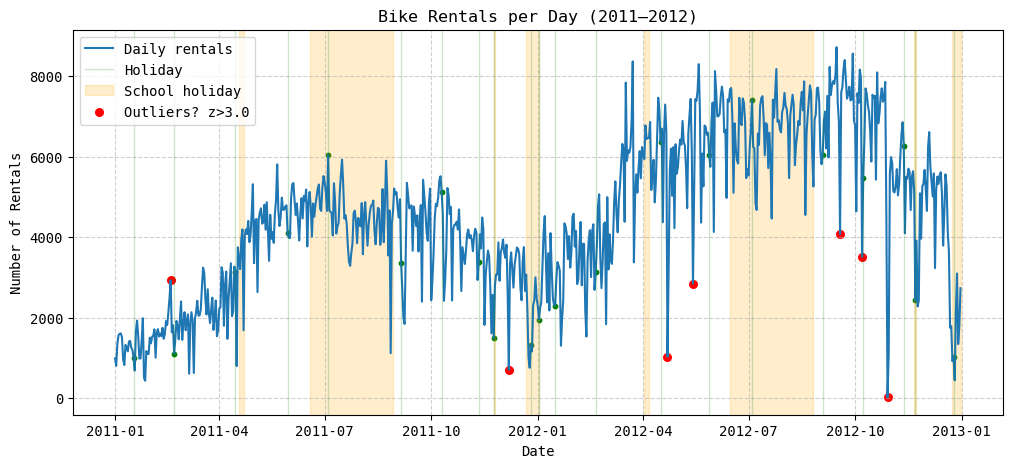

In [25]:
# Remove Hurricane Sandy outlier
df_all = df_all[df_all["dteday"] != "2011-10-29"]

# Plot daily rentals
plt.figure(figsize=(12, 5))
plt.plot(df_all["dteday"], df_all["cnt"], label="Daily rentals")
plt.title("Bike Rentals per Day (2011–2012)")
plt.xlabel("Date")
plt.ylabel("Number of Rentals")
plt.grid(True, linestyle="--", alpha=0.6)

# Plot holidays
df_holiday = df_all[df_all["holiday"] == 1]
for i_hol, date_hol in enumerate(df_holiday["dteday"]):
    plt.scatter(
        date_hol, df_all[df_all["dteday"] == date_hol]["cnt"], color="green", s=10
    )
    plt.axvline(
        x=date_hol,
        color="green",
        linestyle="-",
        alpha=0.2,
        linewidth=1,
        label="Holiday" if i_hol == 0 else "",
    )

# Plot school breaks
for i_break, break_ in enumerate(breaks):
    plt.axvspan(
        df_all.loc[df_all["dteday"] == break_["start"], "dteday"].iloc[0],
        df_all.loc[df_all["dteday"] == break_["end"], "dteday"].iloc[0],
        color="orange",
        alpha=0.2,
        label="School holiday" if i_break == 0 else "",
    )

# Detect outliers
window = 30
rolling_mean = df_all["cnt"].rolling(window=window, center=True).mean()
rolling_std = df_all["cnt"].rolling(window=window, center=True).std()
z_score_local = (df_all["cnt"] - rolling_mean) / rolling_std
z_threshold = 3.0
df_outliers = df_all[np.abs(z_score_local) > z_threshold]
plt.scatter(
    df_outliers["dteday"],
    df_outliers["cnt"],
    color="red",
    s=30,
    label=f"Outliers? z>{z_threshold}",
)

plt.legend()
plt.savefig(saving_dir / "bike_rentals_per_day.png", dpi=150, bbox_inches="tight")

First observations:
- Season wave.
- Growth (see computation below) between 2011 and 2012.
- Some peaks (outliers?)

In [26]:
# Compute rental averages and growth
rental_avg_2011 = df_all[df_all["dteday"].dt.year == 2011]["cnt"].mean()
rental_avg_2012 = df_all[df_all["dteday"].dt.year == 2012]["cnt"].mean()
growth_2011_2012 = (rental_avg_2012 - rental_avg_2011) / rental_avg_2011
print(f"Rental average 2011: {rental_avg_2011:.0f}")
print(f"Rental average 2012: {rental_avg_2012:.0f}")
print(f"2011->2012 Growth: {growth_2011_2012:.0%}")

# November growth
rental_avg_2011_nov = df_all[
    (df_all["dteday"].dt.year == 2011) & (df_all["dteday"].dt.month == 11)
]["cnt"].mean()
rental_avg_2012_nov = df_all[
    (df_all["dteday"].dt.year == 2012) & (df_all["dteday"].dt.month == 11)
]["cnt"].mean()
growth_2011_2012_nov = (rental_avg_2012_nov - rental_avg_2011_nov) / rental_avg_2011_nov
print(f"2011->2012 Growth (Nov only): {growth_2011_2012_nov:.0%}")

Rental average 2011: 3413
Rental average 2012: 5600
2011->2012 Growth: 64%
2011->2012 Growth (Nov only): 49%


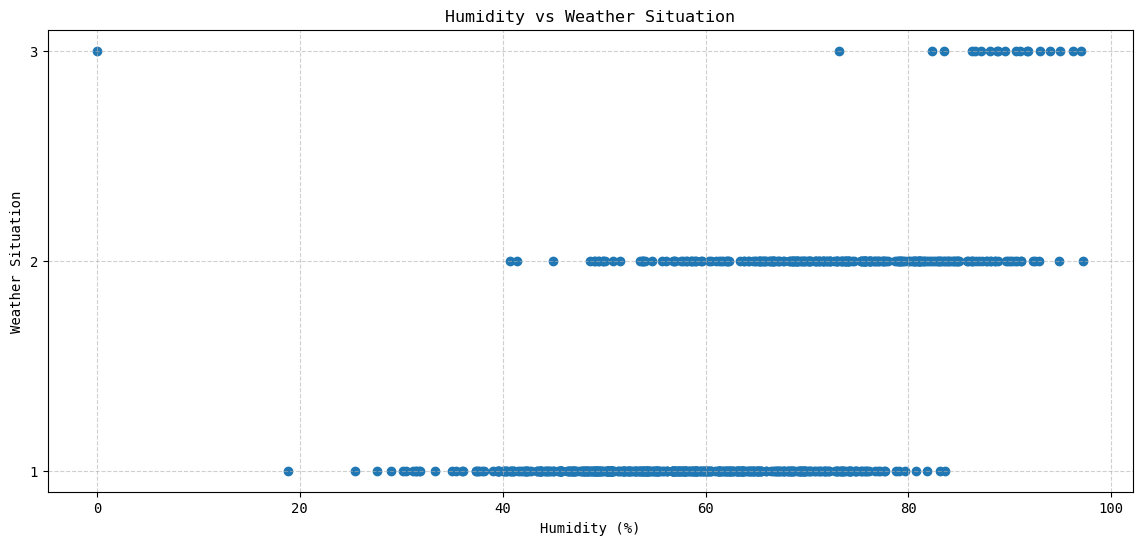

In [27]:
# Plot humidity vs. weathersit
plt.figure(figsize=(14, 6))
plt.scatter(df_all["hum"] * 100, df_all["weathersit"])
plt.xlabel("Humidity (%)")
plt.ylabel("Weather Situation")
plt.title("Humidity vs Weather Situation")
plt.yticks([1, 2, 3])
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(saving_dir / "humidity_vs_weather.png", dpi=150, bbox_inches="tight")

First observations:
- Overlap of classes.
- Outlier at 0% humidity in class #3.
- Strange that the 4th class is unused.

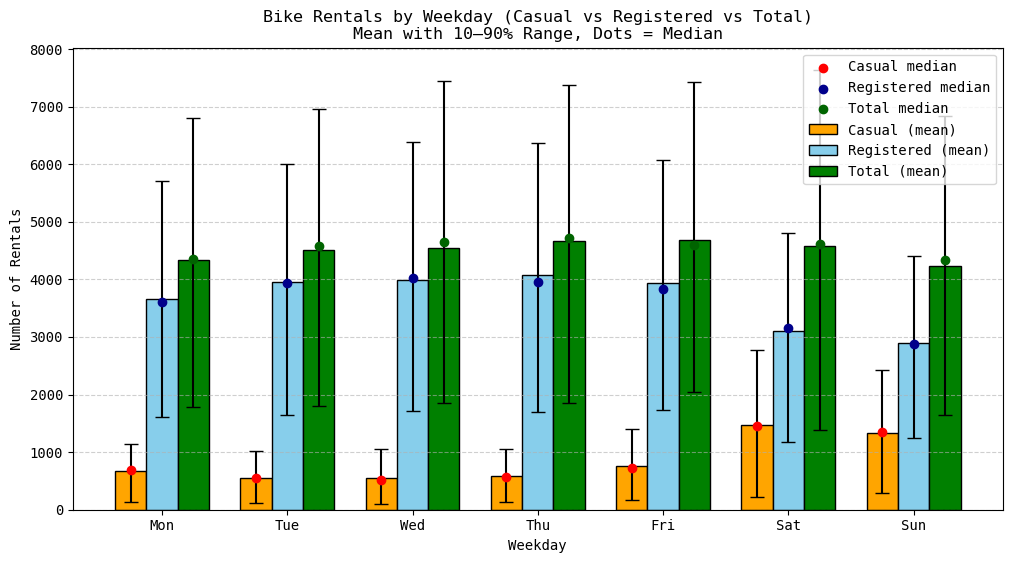

In [28]:
# Compute stats by weekday
def compute_stats(column):
    """Compute statistics for a given column by weekday."""
    return (
        df_all.groupby("weekday_name")[column]
        .agg(
            mean="mean",
            median="median",
            p10=lambda x_: x_.quantile(0.1),
            p90=lambda x_: x_.quantile(0.9),
        )
        .reindex(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    )

stats_casual = compute_stats("casual")
stats_registered = compute_stats("registered")
stats_total = compute_stats("cnt")

# Plot rentals by weekday
x_values = range(len(stats_casual))
width = 0.25
plt.figure(figsize=(12, 6))

# Casual
plt.bar(
    [i - width for i in x_values],
    stats_casual["mean"],
    width=width,
    yerr=[
        stats_casual["mean"] - stats_casual["p10"],
        stats_casual["p90"] - stats_casual["mean"],
    ],
    capsize=5,
    color="orange",
    edgecolor="black",
    label="Casual (mean)",
)
plt.scatter(
    [i - width for i in x_values],
    stats_casual["median"],
    color="red",
    marker="o",
    zorder=3,
    label="Casual median",
)

# Registered
plt.bar(
    x_values,
    stats_registered["mean"],
    width=width,
    yerr=[
        stats_registered["mean"] - stats_registered["p10"],
        stats_registered["p90"] - stats_registered["mean"],
    ],
    capsize=5,
    color="skyblue",
    edgecolor="black",
    label="Registered (mean)",
)
plt.scatter(
    x_values,
    stats_registered["median"],
    color="darkblue",
    marker="o",
    zorder=3,
    label="Registered median",
)

# Total
plt.bar(
    [i + width for i in x_values],
    stats_total["mean"],
    width=width,
    yerr=[
        stats_total["mean"] - stats_total["p10"],
        stats_total["p90"] - stats_total["mean"],
    ],
    capsize=5,
    color="green",
    edgecolor="black",
    label="Total (mean)",
)
plt.scatter(
    [i + width for i in x_values],
    stats_total["median"],
    color="darkgreen",
    marker="o",
    zorder=3,
    label="Total median",
)

plt.xticks(x_values, stats_casual.index)
plt.title("Bike Rentals by Weekday (Casual vs Registered vs Total)\nMean with 10–90% Range, Dots = Median")
plt.ylabel("Number of Rentals")
plt.xlabel("Weekday")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()
plt.savefig(saving_dir / "bike_rentals_weekday.png", dpi=150, bbox_inches="tight")

First observations:
- Stable pattern over the week
- Casual rentals during the weekend
- Registered rentals during the week

Maximum number of bicycles needed: nmax=727
95%-percentile number of bicycles needed: n95=632


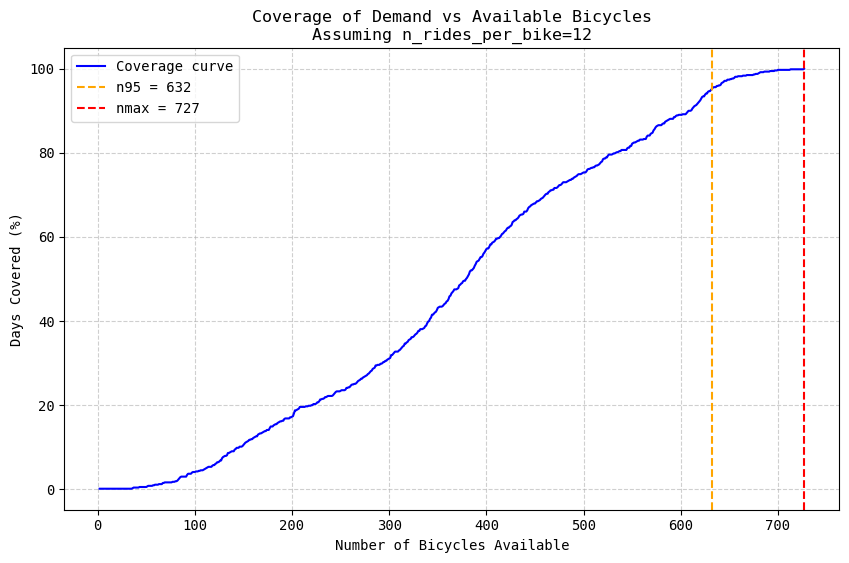

In [29]:
# Compute bikes needed
n_rides_per_bike = 12
df_all["bikes_needed"] = (df_all["cnt"] / n_rides_per_bike).apply(math.ceil)
nmax = df_all["bikes_needed"].max()
n95 = math.ceil(df_all["bikes_needed"].quantile(0.95))
print(f"Maximum number of bicycles needed: {nmax=:.0f}")
print(f"95%-percentile number of bicycles needed: {n95=:.0f}")

# Compute and plot coverage
bike_range = range(df_all["bikes_needed"].min(), df_all["bikes_needed"].max() + 1)
coverage = [(df_all["bikes_needed"] <= n).mean() * 100 for n in bike_range]
plt.figure(figsize=(10, 6))
plt.plot(bike_range, coverage, label="Coverage curve", color="blue")
plt.axvline(n95, color="orange", linestyle="--", label=f"n95 = {n95}")
plt.axvline(nmax, color="red", linestyle="--", label=f"nmax = {nmax}")
plt.title(f"Coverage of Demand vs Available Bicycles\nAssuming {n_rides_per_bike=}")
plt.xlabel("Number of Bicycles Available")
plt.ylabel("Days Covered (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig(saving_dir / "bike_fleet_coverage.png", dpi=150, bbox_inches="tight")

First observations:
- Sigmoid-like shape: only a few high-demand days require up to nmax=727.
- This shape is typical for systems with variable demand, where a threshold (e.g., n95) meets most needs efficiently.
- Starting from 632 bikes, is it worth adding ~100 bikes to fully cover all needs? Probably not.

Business Insight: The **steep middle portion** of the curve indicates that a fleet size between 500 and 650 bicycles captures most of the demand variability. This range is critical for optimizing fleet size to minimize costs while maintaining high service reliability.

## Part 3: Building Prediction Models

**Objective**: Build a Random Forest model to predict daily bike demand and evaluate it using Mean Absolute Error (MAE).

**Steps**:
- **Metric Choice**: Use MAE to measure prediction accuracy, as it directly represents the average error in rentals per day, which is intuitive for bike fleet planning.
- **Feature Selection**: Use features like `season`, `yr`, `mnth`, `holiday`, `holiday_break`, `weekday`, `workingday`, `weathersit`, `temp`, `atemp`, `hum`, `windspeed`. Exclude `cnt` (target) and redundant features after correlation analysis.
- **Model Training**: Train a Random Forest Regressor on the training data (Jan 2011-Nov 2012) and evaluate on the test set.
- **Baselines**: Compare with a model trained on December 2011 data (adjusted for growth) and a simple average baseline.
- **Evaluation**: Predict rentals for the last 30 days and report MAE.

**Notes:**
- _As an exercise, it is interesting to try to predict the rentals for December 2012._
- _But I do not think it is really relevant to make prediction for one full month. Because in reality this will not be possible to predict the weather for one month._
- _I would deem it more relevant to predict the rentals for the next few days. To know how many additional bicycles are needed. I.e. short horizon only._
- _In addition, December is really particular, with holidays and weather conditions._
- _But that is the exercise, isn't it?_

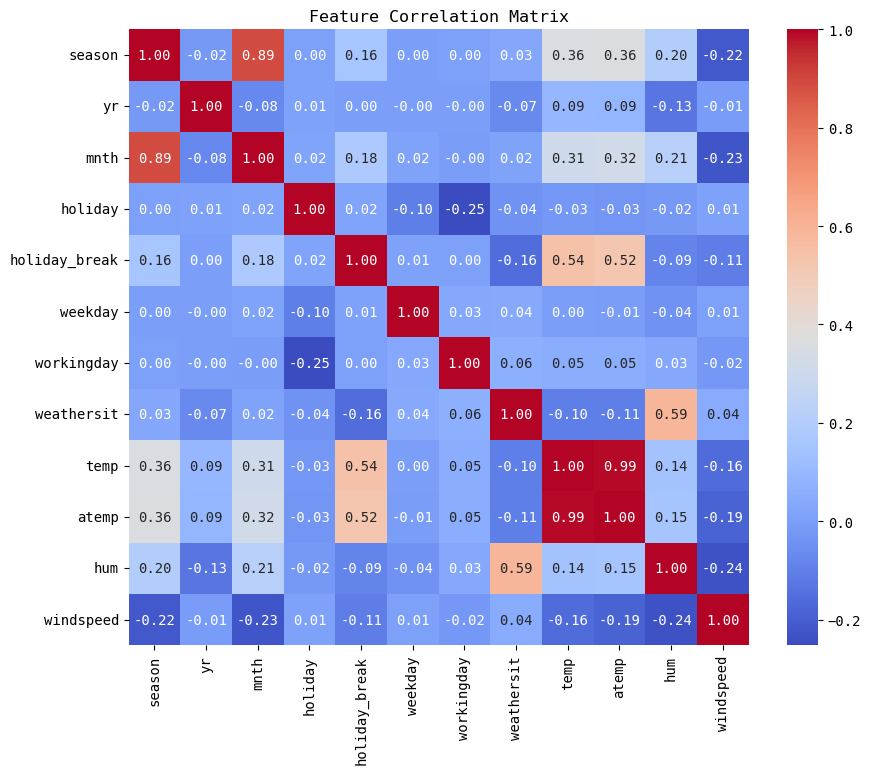

In [30]:
# Define features
feature_cols = [
    "season",
    "yr",
    "mnth",
    "holiday",
    "holiday_break",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
]

# Correlation analysis
corr = df[feature_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.savefig(saving_dir / "feature_correlation_matrix.png", dpi=150, bbox_inches="tight")

# Remove redundant features
# It turned out to be detrimental
# feature_cols = [col for col in feature_cols if col not in ["atemp", "season"]]

In [31]:
def train_model(df_, feature_cols_, name_, test_size=0.2, grid_search=False):
    """Train a Random Forest model and evaluate its performance."""
    x = df_[feature_cols_]
    y = df_["cnt"]
    x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
        x, y, df_.index, test_size=test_size, random_state=42
    )

    model = RandomForestRegressor(random_state=42)
    if grid_search:
        # Define the hyperparameter search space
        param_grid = {
            # Number of trees in the Random Forest.
            # More trees can improve performance but increase computation time.
            "n_estimators": [100, 200, 500],
            # Maximum depth of each tree.
            # None means nodes are expanded until all leaves are pure or contain < min_samples_split samples.
            # Shallower trees (lower max_depth) can prevent overfitting.
            "max_depth": [None, 10, 20, 30],
            # Minimum number of samples required to split an internal node.
            # Higher values reduce overfitting by making trees less complex.
            "min_samples_split": [2, 5, 10],
            # Minimum number of samples required to be at a leaf node.
            # Higher values prevent small leaf nodes that capture noise.
            "min_samples_leaf": [1, 2, 4],
            # Number of features to consider when looking for the best split.
            # 'auto' uses all features, 'sqrt' uses square root of number of features.
            # Helps control randomness and can reduce correlation between trees.
            "max_features": ["auto", "sqrt"],
        }

        # Setup the Grid Search
        grid_search = GridSearchCV(
            estimator=model,  # The base estimator, here a RandomForestRegressor
            param_grid=param_grid,  # Dictionary of hyperparameters to try
            cv=5,  # 5-fold cross-validation:
            # splits data into 5 parts, trains on 4 and validates on 1, repeated 5 times
            scoring="neg_mean_absolute_error",  # Metric to evaluate model performance during CV.
            # Using neg MAE because sklearn wants a "score" to maximize.
            n_jobs=-1,  # Use all available CPU cores to speed up computation
            verbose=2,
        )

        grid_search.fit(x, y)
        print(f"{name_}: {grid_search.best_params_ = }")
        model = RandomForestRegressor(**grid_search.best_params_, random_state=42)

    model.fit(x_train, y_train)

    # Feature importances
    importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print(importances)
    importances.plot(kind="barh", figsize=(8, 6))
    plt.title(f"Random Forest Feature Importances\n{name_}")
    plt.savefig(saving_dir / f"feature_importances_{name_}.png", dpi=150, bbox_inches="tight")

    # Evaluate
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Training model for {name_}:")
    print(f"\tTest MAE: {mae:.2f} rentals/day")
    print(f"\tTest RMSE: {rmse:.2f} rentals/day")

    # Store predictions
    df_["prediction"] = np.nan
    df_.loc[idx_test, "prediction"] = y_pred

    if len(y_pred)>3:
        # Plot predictions
        plt.figure(figsize=(14, 6))
        plt.plot(df_["dteday"], df_["cnt"], label="Actual demand", color="black", alpha=0.7)
        plt.scatter(
            df_.loc[idx_test, "dteday"],
            df_.loc[idx_test, "prediction"],
            label="Predicted demand (test set)",
            color="red",
            alpha=0.7,
            s=15,
        )
        plt.title("Bike Sharing Demand Prediction (Random Forest)\nActual vs Predicted")
        plt.xlabel("Date")
        plt.ylabel("Number of Rentals")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend()
        plt.savefig(saving_dir / f"bike_demand_prediction_{name_}.png", dpi=150, bbox_inches="tight")

    return model

In [32]:
def evaluate(df_, names):
    """Evaluate multiple models on the last 30 days."""
    results = {}
    colours = ["red", "blue", "green", "orange", "purple"]
    actual = df_["cnt"]
    plt.figure(figsize=(14, 6))
    for i_name, name_ in enumerate(names):
        predicted = df_[name_]
        mae = mean_absolute_error(actual, predicted)
        results[name_] = mae
        print(f"{name_}\n\tMAE: {mae:.0f} rentals/day")
        plt.plot(df_["dteday"], actual, label="Actual" if i_name == 0 else None, color="black")
        plt.plot(df_["dteday"], predicted, label=f"{name_} ({mae=:.0f})", color=colours[i_name])

    df_no_work = df_[df_["workingday"] == 0]
    plt.scatter(
        df_no_work["dteday"],
        df_no_work["cnt"],
        color="black",
        s=50,
        alpha=0.5,
        label="Weekend or Holiday",
    )
    plt.ylim(0, None)
    plt.title("Actual vs Predicted (Last 30 Days)")
    plt.xlabel("Day")
    plt.ylabel("Number of Rentals")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.savefig(saving_dir / "eval.png", dpi=150, bbox_inches="tight")

    print("\nResults:")
    for name_, mae in results.items():
        print(f"{name_:<24}: MAE={mae:.0f} rentals/day")

temp             0.332512
yr               0.318779
atemp            0.149021
hum              0.053266
mnth             0.045164
season           0.036776
windspeed        0.026625
weathersit       0.016056
weekday          0.014115
workingday       0.003560
holiday_break    0.002510
holiday          0.001614
dtype: float64
Training model for train_Jan11_Nov12:
	Test MAE: 510.23 rentals/day
	Test RMSE: 790.88 rentals/day


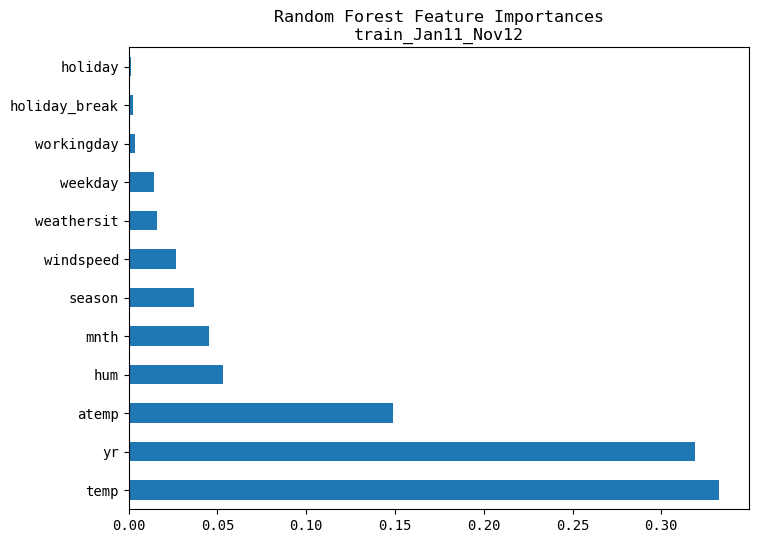

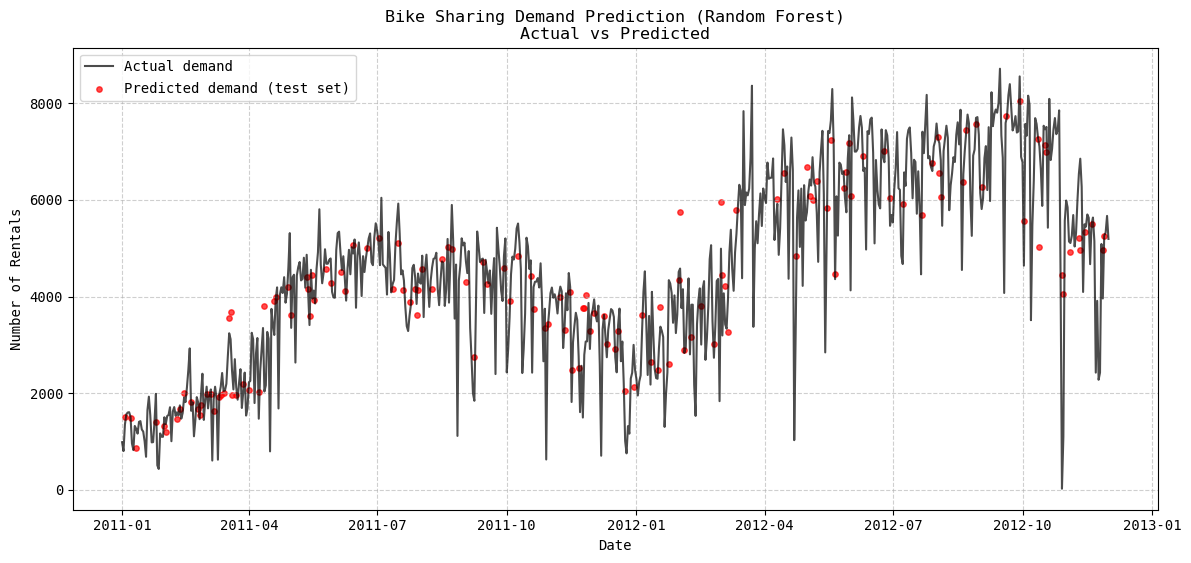

In [33]:
# Train models
evaluation_names = []
name = "train_Jan11_Nov12"
model_all = train_model(
    df,
    feature_cols,
    name,
    # grid_search=True,  # this was reducing MAE of 10 rentals/day but takes much longer
)
df_last30[name] = model_all.predict(df_last30[feature_cols])
evaluation_names.append(name)

season           0.292287
holiday_break    0.266174
atemp            0.116535
weekday          0.097664
temp             0.088123
windspeed        0.076203
workingday       0.031651
hum              0.022424
weathersit       0.007182
holiday          0.001759
yr               0.000000
mnth             0.000000
dtype: float64
Training model for train_Dec11:
	Test MAE: 240.47 rentals/day
	Test RMSE: 240.47 rentals/day


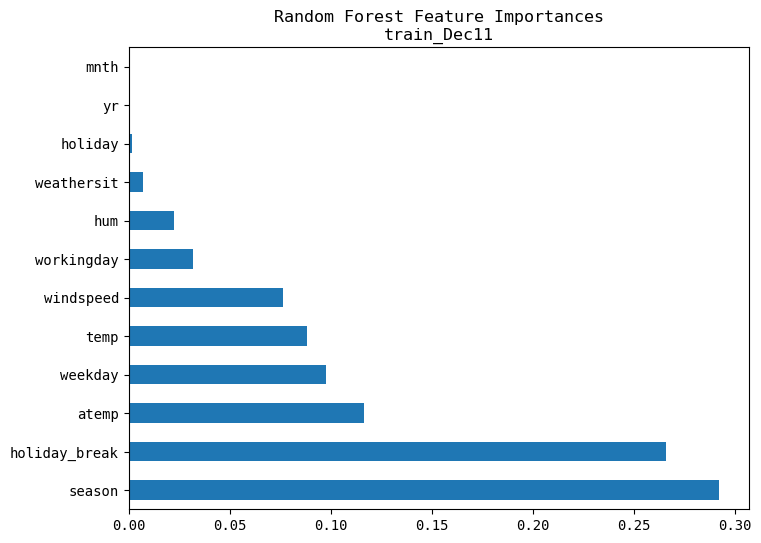

In [34]:
# Baseline: December 2011 model
name = "train_Dec11"
model_dec2011 = train_model(
    df[(df["mnth"] == 12) & (df["yr"] == 0) & ~df.index.isin(df_outliers.index)].copy(),
    feature_cols,
    name,
    test_size=0.02,
)
df_last30[name] = model_dec2011.predict(df_last30[feature_cols]) * (1 + growth_2011_2012_nov)
evaluation_names.append(name)

First observations:
- It was worth adding `holiday_break`.
- `season` is important. But it is probably because Dec 21th is the start of the Winter Break.

In [35]:
# Baseline: December 2011 average, corrected with growth
name = "corrected_avg_dec_2011"
dec_2011_mean = df[(df["mnth"] == 12) & (df["yr"] == 0)]["cnt"].mean()
df_last30[name] = dec_2011_mean * (1 + growth_2011_2012_nov)
evaluation_names.append(name)

train_Jan11_Nov12
	MAE: 728 rentals/day
train_Dec11
	MAE: 843 rentals/day
corrected_avg_dec_2011
	MAE: 1553 rentals/day

Results:
train_Jan11_Nov12       : MAE=728 rentals/day
train_Dec11             : MAE=843 rentals/day
corrected_avg_dec_2011  : MAE=1553 rentals/day


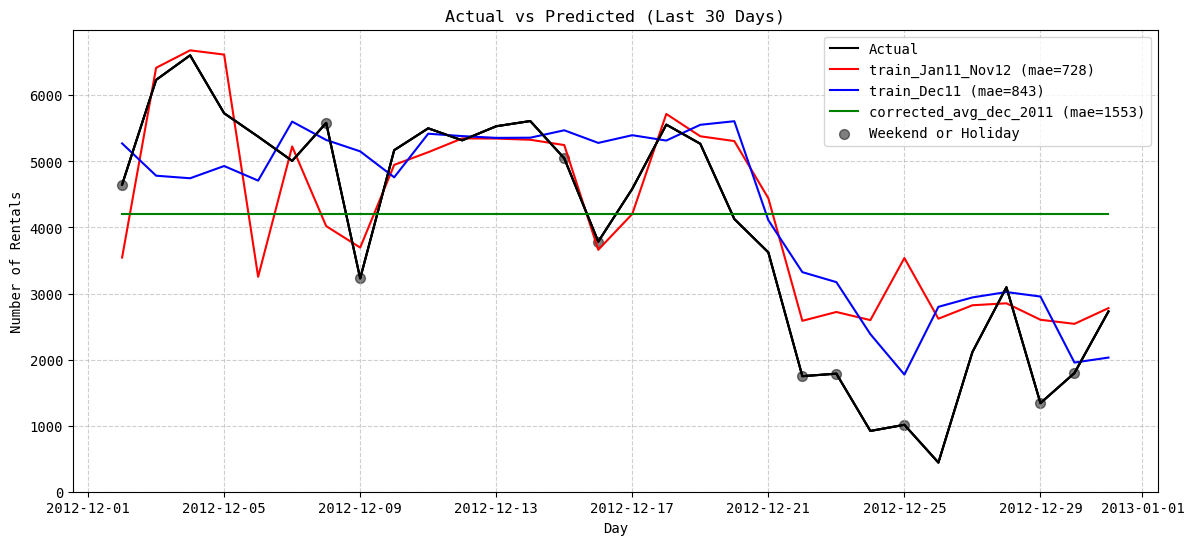

In [36]:
# Evaluate models
evaluate(df_last30, evaluation_names)

## Part 4: Reflection and Comments

**Key Observations**:
- **Data Insights**:
  - Significant growth in rentals from 2011 to 2012 (+64% overall), indicating increasing demand.
  - Seasonal patterns: Higher rentals in summer, lower in winter.
  - Casual rentals peak on weekends, while registered rentals are stable on weekdays, reflecting commuting vs. leisure use.
  - Holidays and school breaks reduce demand, especially for registered users.
- **Challenges**:
  - Predicting December 2012 rentals is difficult due to unique cultural patterns (e.g., Christmas) not fully captured in the data.
  - Weather features (`weathersit`, `hum`, `temp`) are critical but require short-term forecasts for practical use.
  - The dataset lacks geolocation data for bike stations, which could reveal spatial demand variations.
- **Model Performance**:
  - The Random Forest model (trained on `Jan 2011-Nov 2012`) outperforms baselines but struggles with holiday effects.
  - The model trained on `Dec11` correctly captures the Christmas time. `holiday_break` is has a strong feature importance.
  - MAE of ~600–800 rentals/day suggests room for improvement, possibly with additional features (e.g., station-specific data).
- **Improvements**:
  - Incorporate categorical encoding (e.g., OneHotEncoder for `mnth` and `season`) to better capture categorical effects.
  - Add interaction features (e.g., `temp * hum`) to model combined effects. I have tried but it did non improve.
  - Use prediction intervals from Random Forest trees to quantify uncertainty.
  - Should I include previous day's rentals? I do not think so. To me, the chain of days can be modeled as Markovian.
- **Practical Considerations**:
  - The model is most useful for short-term forecasting (1–3 days) due to weather unpredictability.
  - Fleet sizing should balance `n95` (cost-effective) vs. `nmax` (full coverage) based on business goals.

**Feedback**:
- Including geolocation or station-specific data could enhance the analysis.
- Clearer guidance on the prediction horizon (short-term vs. long-term) would help focus the modeling approach.